# EV Charging Demand forecasting

In [2]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astral.sun import sun, zenith
from astral import LocationInfo
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor

import statsmodels.api as sm
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from mapie.metrics import regression_mean_width_score, regression_coverage_score

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

In [3]:
modelFolder = "Models"
if not os.path.exists(modelFolder):
    os.makedirs(modelFolder)

In [4]:
evalFolder = "EnergyHubEval"
if not os.path.exists(evalFolder):
    os.makedirs(evalFolder)

In [5]:
random_state = 77

## Data exploration

In [6]:
yearTest = 2021

In [7]:
directory = 'Data/EV_CA_US/'
all_files = sorted([f for f in os.listdir(directory) if f.startswith('allPower')])
print(f'reading: {all_files}')

all_dfs = []
for i, file in enumerate(all_files):
    df = pd.read_csv(os.path.join(directory, file), index_col=0)
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert('America/Los_Angeles')
    
    if i < len(all_files) - 1:
        next_df = pd.read_csv(os.path.join(directory, all_files[i + 1]), index_col=0)
        next_df['datetime'] = pd.to_datetime(next_df['datetime'], utc=True).dt.tz_convert('America/Los_Angeles')
        end_date = next_df['datetime'].min()
        df = df[df['datetime'] < end_date]
    
    all_dfs.append(df)

allEVAgg = pd.concat(all_dfs, ignore_index=True)

reading: ['allPower_30MAX_182.5D_0.25H_2019-01-01_2019-07-03.csv', 'allPower_30MAX_182.5D_0.25H_2019-07-01_2019-12-31.csv', 'allPower_30MAX_182.5D_0.25H_2020-01-01_2020-07-02.csv', 'allPower_30MAX_182.5D_0.25H_2020-07-01_2020-12-31.csv', 'allPower_30MAX_182.5D_0.25H_2021-01-01_2021-07-03.csv', 'allPower_30MAX_182.5D_0.25H_2021-07-01_2021-12-31.csv']


In [8]:
allEVAgg.head()

,datetime,nSessions,TotPowerEqBin,delayAgg
0,2019-01-01 00:00:00-08:00,0,0.000000,0.0
1,2019-01-01 00:15:00-08:00,1,4.202491,0.0
2,2019-01-01 00:30:00-08:00,1,4.202491,0.0
3,2019-01-01 00:45:00-08:00,1,4.202491,0.0
4,2019-01-01 01:00:00-08:00,1,4.202491,0.0


In [9]:
allEVAgg['TotPowerEqBin'].max()

np.float64(156.92546177435923)

<Axes: xlabel='datetime'>

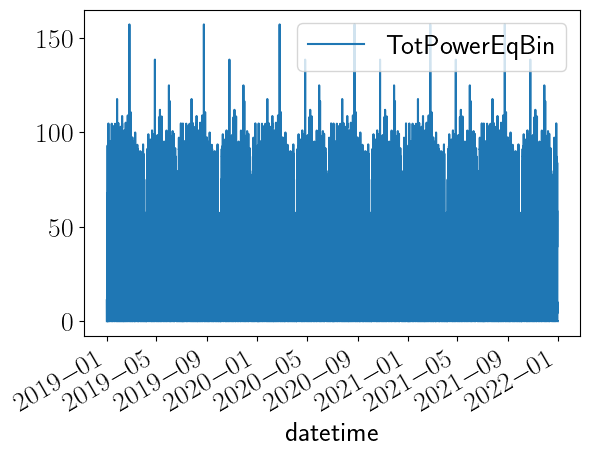

In [10]:
allEVAgg.plot(x='datetime', y='TotPowerEqBin')

In [11]:
allEVAgg

,datetime,nSessions,TotPowerEqBin,delayAgg
0,2019-01-01 00:00:00-08:00,0,0.000000,0.0
1,2019-01-01 00:15:00-08:00,1,4.202491,0.0
2,2019-01-01 00:30:00-08:00,1,4.202491,0.0
3,2019-01-01 00:45:00-08:00,1,4.202491,0.0
4,2019-01-01 01:00:00-08:00,1,4.202491,0.0
...,...,...,...,...
105055,2021-12-31 09:45:00-08:00,0,0.000000,0.0
105056,2021-12-31 10:00:00-08:00,0,0.000000,0.0
105057,2021-12-31 10:15:00-08:00,0,0.000000,0.0
105058,2021-12-31 10:30:00-08:00,0,0.000000,0.0


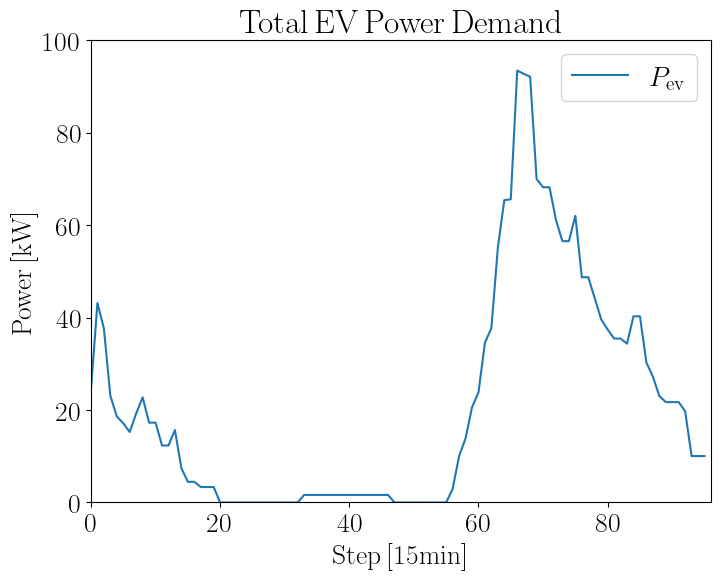

In [12]:
plt.figure(figsize=(8, 6))

plt.plot(range(96), allEVAgg.loc[allEVAgg['datetime'].dt.date == pd.to_datetime('2021-07-05').date(), 'TotPowerEqBin'], label=r'$P_\mathrm{ev}$')
plt.xlabel(r'$\mathrm{Step \, [15min]}$')
plt.ylabel(r'$\mathrm{Power \, [kW]}$')
plt.title(r'$\mathrm{Total\, EV \, Power \, Demand}$')
plt.legend()
plt.xlim(0, 96)
plt.ylim(0, 100)

# plt.savefig('Figures/Aggregated_Power_ev.svg', format='svg', dpi=300, bbox_inches='tight')

plt.show()

In [13]:
PowerAgg = allEVAgg.loc[:, ['datetime', 'TotPowerEqBin']].copy()
PowerAgg['datetime'] = pd.to_datetime(PowerAgg['datetime'], utc=True).dt.tz_convert('America/Los_Angeles')
PowerAgg.columns = ['datetime', 'Power']

## Feature Engineering

In [14]:
location = LocationInfo("Arbuckle", "America", "America/Los_Angeles", 38.996306, -122.134111)
PowerAgg['date'] = PowerAgg['datetime'].dt.date

sunInfo = pd.DataFrame({'date': pd.Series(dtype='object'), 
                        'sunrise': pd.Series(dtype='datetime64[ns, UTC]')})

for date in PowerAgg['date'].unique():
    s = sun(location.observer, date=date, tzinfo=location.timezone)
    sunInfo = pd.concat([sunInfo, pd.DataFrame({'date': [date], 'sunrise': [s['sunrise']]})], ignore_index=True)

PowerAgg.drop(columns=['date'], inplace=True)

In [15]:
# def calculate_hours_from_sunrise(row, sunInfo):
#     date = row['datetime'].date()
#     sunrise_time = sunInfo.loc[sunInfo['date'] == date, 'sunrise'].values[0]
#     sunrise_seconds = sunrise_time.hour * 3600 + sunrise_time.minute * 60
#     dt_seconds = row['datetime'].hour * 3600 + row['datetime'].minute * 60
#     start_peak = 6
#     # star_valley = 12
#     hours_from_sunrise = (dt_seconds - sunrise_seconds) / 3600
#     # return np.sin(np.pi * (hours_from_sunrise - start_peak) / 12) , -np.sin(np.pi * (hours_from_sunrise - star_valley) / 12)
#     return np.sin(np.pi * (hours_from_sunrise - start_peak) / 12) 

In [16]:
PowerAgg['arrivalHour'] = PowerAgg['datetime'].dt.hour
PowerAgg['isLowArrivalHour'] = PowerAgg['arrivalHour'].between(3, 9)
PowerAgg['dayOfWeek'] = PowerAgg['datetime'].dt.dayofweek
# PowerAgg['weekOfYear'] = PowerAgg['datetime'].dt.isocalendar().week
PowerAgg['monthOfYear'] = PowerAgg['datetime'].dt.month 

# PowerAgg['hoursFromSunrise1'] = PowerAgg.apply(lambda row: calculate_hours_from_sunrise(row, sunInfo=sunInfo), axis=1)
# hours_from_sunrise = PowerAgg.apply(lambda row: calculate_hours_from_sunrise(row, sunInfo=sunInfo), axis=1)
# PowerAgg[['hoursFromSunrise1', 'hoursFromSunrise2']] = pd.DataFrame(hours_from_sunrise.tolist(), index=PowerAgg.index)

n_lags = 0
if n_lags > 0:
    for l in range(1, n_lags + 1):
        PowerAgg[f"IntraDay_{l}"] = PowerAgg["Power"].shift(l)

n_daily_lags = 96
# PowerAgg['Day_sum'] = PowerAgg['Power'].rolling(window=n_daily_lags).sum()

PowerAgg['H-6'] = PowerAgg['Power'].rolling(window=7*4).sum() - PowerAgg['Power'].rolling(window=6*4).sum()
# PowerAgg['H-12'] = PowerAgg['Power'].rolling(window=13*4).sum() - PowerAgg['Power'].rolling(window=12*4).sum()
# PowerAgg['H-18'] = PowerAgg['Power'].rolling(window=19*4).sum() - PowerAgg['Power'].rolling(window=18*4).sum()
min_step_lag = 6 * 4

PowerAgg['date'] = PowerAgg['datetime'].dt.date

daily_sum = PowerAgg.groupby('date')['Power'].sum().reset_index()
daily_sum.columns = ['date', 'sum']
lag_daily_sum = daily_sum.copy()
lag_daily_sum['isoDay_sum'] = daily_sum['sum'].shift(1)
lag_daily_sum.drop(columns=['sum'], inplace=True)

daily_std = PowerAgg.groupby('date')['Power'].std().reset_index()
daily_std.columns = ['date', 'std']
lag_daily_std = daily_std.copy()
lag_daily_std['isoDay_std'] = daily_std['std'].shift(1)
lag_daily_std.drop(columns=['std'], inplace=True)

PowerAgg = PowerAgg.merge(lag_daily_std, on='date', how='left')
PowerAgg = PowerAgg.merge(lag_daily_sum, on='date', how='left')
PowerAgg.drop(columns=['date'], inplace=True)


In [17]:
PowerAgg.dropna(inplace=True)

In [18]:
nTestDays =  70

PowerAgg['date'] = PowerAgg['datetime'].dt.date

winter_dates = PowerAgg.loc[(PowerAgg['datetime'].dt.month >= 1) & (PowerAgg['datetime'].dt.year == yearTest) , 'datetime'].dt.date.unique()
start_winter = 0
test_days_winter = winter_dates[start_winter:start_winter + nTestDays] # (nTestDays + 1)
test_datetimes_winter = PowerAgg[PowerAgg['date'].isin(test_days_winter)]['datetime']
test_datetimes_winter = test_datetimes_winter[test_datetimes_winter.dt.date != pd.to_datetime('2021-03-14').date()].copy() # also remove the prices DST days

spring_dates = PowerAgg.loc[(PowerAgg['datetime'].dt.month >= 4) & (PowerAgg['datetime'].dt.year == yearTest), 'datetime'].dt.date.unique()
start_spring = 0 
test_days_spring = spring_dates[start_spring:start_spring + nTestDays]
test_datetimes_spring = PowerAgg[PowerAgg['date'].isin(test_days_spring)]['datetime']

summer_dates = PowerAgg.loc[(PowerAgg['datetime'].dt.month >= 7) & (PowerAgg['datetime'].dt.year == yearTest), 'datetime'].dt.date.unique()
start_summer = 0
test_days_summer = summer_dates[start_summer:start_summer + (nTestDays + 2)]
test_datetimes_summer = PowerAgg[PowerAgg['date'].isin(test_days_summer)]['datetime']
test_datetimes_summer = test_datetimes_summer[(test_datetimes_summer.dt.date != (pd.to_datetime('2021-07-16').date())) & (test_datetimes_summer.dt.date != (pd.to_datetime('2021-07-17').date()))]

autumn_dates = PowerAgg.loc[(PowerAgg['datetime'].dt.month >= 10) & (PowerAgg['datetime'].dt.year == yearTest), 'datetime'].dt.date.unique()
start_autumn = 0
test_days_autumn = autumn_dates[start_autumn:start_autumn + (nTestDays + 2)]
test_datetimes_autumn = PowerAgg[PowerAgg['date'].isin(test_days_autumn)]['datetime']
test_datetimes_autumn = test_datetimes_autumn[(test_datetimes_autumn.dt.date != pd.to_datetime('2021-11-7').date()) & (test_datetimes_autumn.dt.date != (pd.to_datetime('2021-10-27').date()))].copy() # also remove the prices DST days

test_datetimes = pd.concat([test_datetimes_winter, test_datetimes_spring, test_datetimes_summer, test_datetimes_autumn])

PowerAgg.drop(columns=['date'], inplace=True)

testPowerAgg = PowerAgg[PowerAgg['datetime'].isin(test_datetimes)]
# testPowerAgg = PowerAgg[PowerAgg['datetime'].dt.year == yearTest]
# trainPowerAgg = PowerAgg[~PowerAgg['datetime'].isin(test_datetimes)]
trainPowerAgg = PowerAgg[(PowerAgg['datetime'].dt.year != yearTest)]

testPowerAgg.reset_index(drop=True, inplace=True)
trainPowerAgg.reset_index(drop=True, inplace=True)


In [19]:
print(len(test_datetimes_winter), len(test_datetimes_spring), len(test_datetimes_summer), len(test_datetimes_autumn))
print(testPowerAgg[testPowerAgg['datetime'].isin(test_datetimes_winter)].shape[0], testPowerAgg[testPowerAgg['datetime'].isin(test_datetimes_spring)].shape[0], testPowerAgg[testPowerAgg['datetime'].isin(test_datetimes_summer)].shape[0], testPowerAgg[testPowerAgg['datetime'].isin(test_datetimes_autumn)].shape[0])

6720 6720 6720 6720
6720 6720 6720 6720


In [20]:
print(testPowerAgg.shape[0], len(test_datetimes))

26880 26880


In [21]:
X_trainPowerAgg = trainPowerAgg.drop(columns=['datetime', 'Power'])
y_trainPowerAgg = trainPowerAgg[['datetime', 'Power']]
X_testPowerAgg = testPowerAgg.drop(columns=['datetime']) # keep Power to build rolling features during n_ahead predictions
y_testPowerAgg = testPowerAgg[['datetime', 'Power']]

## Train

In [22]:
# mapie_enbpi = pickle.load(open(f'{modelFolder}/Pev_MapieGBRv2_yearTest2021.pkl', 'rb'))

In [23]:
init_estimator = DummyRegressor(strategy='mean')
model = GradientBoostingRegressor(n_estimators=100, max_depth=20, learning_rate=0.1, validation_fraction=0.1, n_iter_no_change=15, loss='absolute_error', init=init_estimator, random_state=random_state)

In [24]:
cv_mapiets = BlockBootstrap(n_resamplings=15, length=96, overlapping=False, random_state=random_state)
mapie_enbpi = MapieTimeSeriesRegressor(model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1)
mapie_enbpi = mapie_enbpi.fit(X_trainPowerAgg, y_trainPowerAgg['Power'])

/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/.venv/lib/python3.11/site-packages/mapie/utils.py:565: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/diego/VSCode/ChargingEnergyHubs_StochasticMPC/.venv/lib/python3.11/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


In [25]:
modelName = 'Pev_MapieGBRv2_yearTest' + str(yearTest)

In [26]:
pickle.dump(mapie_enbpi, open(f'{modelFolder}/{modelName}.pkl', 'wb'))

## n-ahead preds

In [27]:
def predict_n_ahead(model, alphas, X, n_ahead, n_lags, n_daily_lags):
    y_preds = np.zeros(len(X))
    y_MAPIEs = np.zeros((len(X), len(alphas), 2))
    X.reset_index(drop=True, inplace=True)

    for i in range(n_daily_lags, len(X), n_ahead):
        
        X_rolling_features_segment = X.iloc[i - n_daily_lags: i].copy()
        X_rolling_features_segment.reset_index(drop=True, inplace=True)
        X_test_segment = X.iloc[i:i + n_ahead].copy()
        X_test_segment.loc[:, 'isoDay_sum'] = X_test_segment['isoDay_sum'].iloc[0] # only the first value of isoDay_sum is known
        X_test_segment.loc[:, 'isoDay_std'] = X_test_segment['isoDay_std'].iloc[0] 
        X_test_segment.drop(columns=['Power'], inplace=True) # remove Power from X_test
        if X_test_segment.shape[0] < n_ahead:
            break
          
        for step in range(n_ahead):
            if i + step >= len(X):
                break
            
            warnings.filterwarnings("ignore")
            for a in range(len(alphas)):
                pred, ci = model.predict(X_test_segment.iloc[step:step+1], alpha=alphas[a], ensemble=False, allow_infinite_bounds=False, optimize_beta=False)
                y_preds[i + step] = pred[:]
                y_MAPIEs[i + step, a, :] = np.clip(ci.flatten(), a_min=0, a_max=None)

            # recompute rolling features
            if step + 1 < n_ahead: 
                X_rolling_features_segment = pd.concat([X_rolling_features_segment.iloc[1:], X_rolling_features_segment.iloc[-1:]], ignore_index=True)
                X_rolling_features_segment.iloc[-1:, X_rolling_features_segment.columns.get_loc('Power')] = pred[:]

                if step + 1 < len(X_test_segment):
                    X_rolling_features_test_segment = pd.concat([X_rolling_features_segment, X_test_segment.iloc[step+1:step+2*1, :]], ignore_index=True)
                    X_rolling_features_test_segment.fillna(0, inplace=True)
                    X_rolling_features_test_segment['H-6'] = X_rolling_features_test_segment['Power'].rolling(window=7*4).sum() - X_rolling_features_test_segment['Power'].rolling(window=6*4).sum()
                    # X_rolling_features_test_segment['H-12'] = X_rolling_features_test_segment['Power'].rolling(window=13*4).sum() - X_rolling_features_test_segment['Power'].rolling(window=12*4).sum()
                    # X_rolling_features_test_segment['H-18'] = X_rolling_features_test_segment['Power'].rolling(window=19*4).sum() - X_rolling_features_test_segment['Power'].rolling(window=18*4).sum()
                    X_test_segment.iloc[step+1:step+2*1, X_test_segment.columns.get_loc('H-6')] = X_rolling_features_test_segment.iloc[-1:, X_rolling_features_test_segment.columns.get_loc('H-6')]
                    # X_test_segment.iloc[step+1:step+2*1, X_test_segment.columns.get_loc('H-12')] = X_rolling_features_test_segment.iloc[-1:, X_rolling_features_test_segment.columns.get_loc('H-12')]
                    # X_test_segment.iloc[step+1:step+2*1, X_test_segment.columns.get_loc('H-18')] = X_rolling_features_test_segment.iloc[-1:, X_rolling_features_test_segment.columns.get_loc('H-18')]

                # if n_lags > 0:
                #     for lag in range(1, n_lags + 1):
                #         if step + lag < n_ahead and step + lag < len(X_test_segment):
                #             X_test_segment.iloc[step + lag, X_test_segment.columns.get_loc(f'IntraDay_{lag}')] = pred

    return y_preds, y_MAPIEs

In [28]:
starting_hour = 0 
res_dict = {}
mapies_dict = {}
# alphas = [0.15, 0.25]
alphas = [0.1]

for h in [24, 12, 3] : # [24, 12, 3] # [24]
    horizon = np.int64(h * 4)  if h > 0 else 1
    X_start_copy = X_testPowerAgg.copy()
    y_start_copy = y_testPowerAgg.copy()
    preds, mapies = predict_n_ahead(model=mapie_enbpi, alphas=alphas,
                                    X=X_start_copy, n_ahead=horizon, n_lags=n_lags, n_daily_lags=n_daily_lags)

    results = pd.DataFrame({'datetime': y_start_copy['datetime'], 'Power': y_start_copy['Power'], 'model': preds})
    results['AE'] = np.abs(results['Power'] - results['model'])
    results['bias'] = results['model'] - results['Power']

    coverage_enbpi_npfit = regression_coverage_score(
        results['Power'], mapies[:, 0, 0], mapies[:, 0, 1])
    width_enbpi_npfit = regression_mean_width_score(
        mapies[:, 0, 0], mapies[:, 0, 1])

    print(f"MAE: {np.round(results['AE'].mean(), 2)}. nMAE: {np.round(results['AE'].mean()/(results['AE'].max()-results['AE'].min()), 4)}. Avg bias: {np.round(results['bias'].mean(), 2)}")
    print(f'Coverage: {coverage_enbpi_npfit:.4f}. Width: {width_enbpi_npfit:.3f}')
        
    res_dict[h] = results
    mapies_dict[h] = mapies

MAE: 4.03. nMAE: 0.0485. Avg bias: 0.2
Coverage: 0.9048. Width: 24.361
MAE: 3.37. nMAE: 0.0422. Avg bias: -0.18
Coverage: 0.9244. Width: 24.316
MAE: 2.63. nMAE: 0.0328. Avg bias: -0.29
Coverage: 0.9437. Width: 24.317


#### Comparison

In [29]:
maxRangeAE = (res_dict[24]['AE']).max() - (res_dict[24]['AE']).min()
maxRangeAE

np.float64(83.16405629043985)

In [30]:
noTitlePlots = True

MAE: 4.26. nMAE: 0.0512. Avg bias: -0.09
Coverage: 0.9009. Width: 24.317
MAE: 3.82. nMAE: 0.046. Avg bias: -0.17
Coverage: 0.9131. Width: 24.317
MAE: 3.05. nMAE: 0.0367. Avg bias: -0.34
Coverage: 0.9357. Width: 24.317


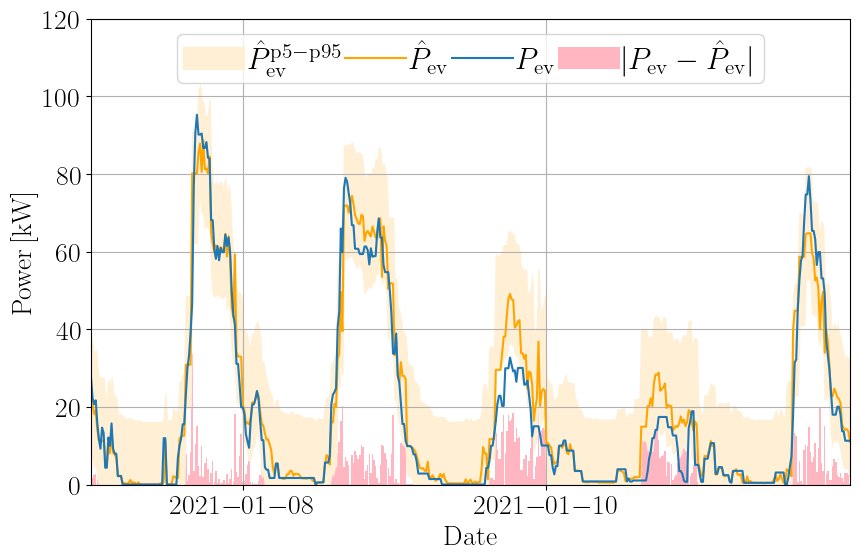

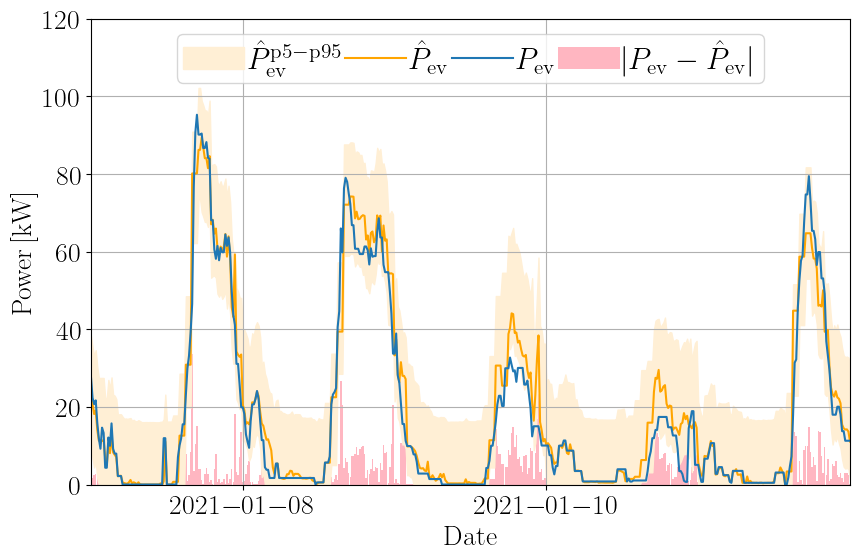

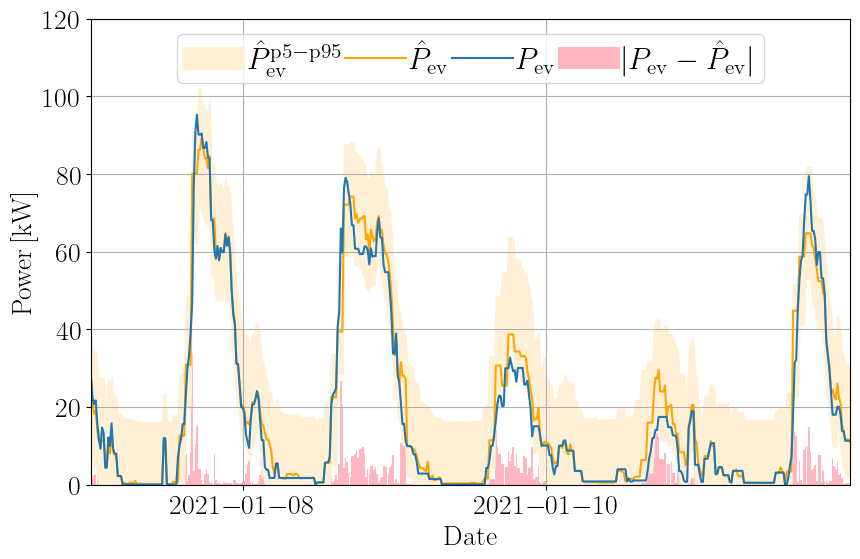

In [31]:
starting_hour = 0
days = 5 
start_days = 6 
season = 'winter'

for h, results in res_dict.items():
    horizon = np.int64(h * 4)  if h > 0 else 1
    mapies = mapies_dict[h]
    
    if len(alphas) == 2:
        pLows = pd.DataFrame({'datetime': results['datetime'], 'P' + str(np.int64(alphas[0]*100)) :mapies[:, 0, 0], 'P' + str(np.int64(alphas[1]*100)): mapies[:, 1, 0]})
        pHighs = pd.DataFrame({'datetime': results['datetime'], 'P' + str(np.int64((1 - alphas[0])*100)) :mapies[:, 0, 1], 'P' + str(np.int64((1 - alphas[1])*100)): mapies[:, 1, 1]})
    else:
        pLows = pd.DataFrame({'datetime': results['datetime'], 'P' + str(np.int64(alphas[0]/2*100)) :mapies[:, 0, 0]})
        pHighs = pd.DataFrame({'datetime': results['datetime'], 'P' + str(np.int64((1 - alphas[0]/2)*100)) :mapies[:, 0, 1]})

    if season == 'winter':
        results = results[results['datetime'].dt.date.isin(test_days_winter)]
        pLows = pLows[pLows['datetime'].dt.date.isin(test_days_winter)]
        pHighs = pHighs[pHighs['datetime'].dt.date.isin(test_days_winter)]
    elif season == 'spring':
        results = results[results['datetime'].dt.date.isin(test_days_spring)]
        pLows = pLows[pLows['datetime'].dt.date.isin(test_days_spring)]
        pHighs = pHighs[pHighs['datetime'].dt.date.isin(test_days_spring)]
    elif season == 'summer':
        results = results[results['datetime'].dt.date.isin(test_days_summer)]
        pLows = pLows[pLows['datetime'].dt.date.isin(test_days_summer)]
        pHighs = pHighs[pHighs['datetime'].dt.date.isin(test_days_summer)]
    elif season == 'autumn':
        results = results[results['datetime'].dt.date.isin(test_days_autumn)]
        pLows = pLows[pLows['datetime'].dt.date.isin(test_days_autumn)]
        pHighs = pHighs[pHighs['datetime'].dt.date.isin(test_days_autumn)]

    coverage_enbpi_npfit = regression_coverage_score(
        results['Power'], pLows.iloc[:, 1], pHighs.iloc[:, 1])
    print(f"MAE: {np.round(results['AE'].mean(), 2)}. nMAE: {np.round(results['AE'].mean()/maxRangeAE, 4)}. Avg bias: {np.round(results['bias'].mean(), 2)}")
    print(f'Coverage: {coverage_enbpi_npfit:.4f}. Width: {width_enbpi_npfit:.3f}')    

    results = results.loc[(results['datetime'] <= (results.iloc[0, 0] + pd.Timedelta(days=(days + start_days)))) & 
                          (results['datetime'] >= (results.iloc[0, 0] + pd.Timedelta(days=start_days))), :]
    pLows = pLows.loc[(pLows['datetime'] <= (pLows.iloc[0, 0] + pd.Timedelta(days=(days + start_days)))) & 
                      (pLows['datetime'] >= (pLows.iloc[0, 0] + pd.Timedelta(days=start_days))), :]
    pHighs = pHighs.loc[(pHighs['datetime'] <= (pHighs.iloc[0, 0] + pd.Timedelta(days=(days + start_days)))) & 
                        (pHighs['datetime'] >= (pHighs.iloc[0, 0] + pd.Timedelta(days=start_days))), :]
    

    # plt.figure(figsize=(12, 8))
    plt.figure(figsize=(9, 6))

    plt.bar(results['datetime'], results['AE'], width=0.01, color='lightpink', label=r'$|P_\mathrm{ev} - \hat{P}_\mathrm{ev}|$')
    plt.fill_between(pLows['datetime'], pLows.iloc[:, 1], pHighs.iloc[:, 1], color='papayawhip', label=r'$\hat{P}_\mathrm{ev}^{\mathrm{p}5-\mathrm{p}95}$')
    if len(alphas) == 2:
        plt.fill_between(pLows['datetime'], pLows['P25'], pHighs['P75'], color='papayawhip', label=r'$\hat{P}_\mathrm{ev}^{\mathrm{p}25-\mathrm{p}75}$')
    plt.plot(results['datetime'], results['model'], label=r'$\hat{P}_\mathrm{ev}$', color='orange')
    plt.plot(results['datetime'], results['Power'], label=r'$P_\mathrm{ev}$', color='tab:blue')
    plt.xlabel(r'$\mathrm{Date}$')
    plt.xlim(results['datetime'].min(), results['datetime'].max())
    # plt.xticks(results['datetime'][::96*2]) #, rotation=45)  # Show every 96th datetime label
    # plt.xticks(results['datetime'][96:-1:96*2]) #, rotation=45)  # Show every 96th datetime label
    plt.xticks(results['datetime'][96:-1:96*np.int64(2)]) #, rotation=45)  # Show every 96th datetime label
    # plt.xticks(results['datetime'][96:-1:96*np.int64(days/4)]) #, rotation=45)  # Show every 96th datetime label
    plt.ylim(0, 116)
    plt.ylabel(r'$\mathrm{Power \, [kW]}$')
    if not noTitlePlots:
        plt.title(rf'${np.int64(horizon/4)}\mathrm{{h\,Ahead\,Prediction\,at\,H0\,}}\mathrm{{(15min\,res.)}}$')
    plt.legend(loc='upper center', ncol=4, handletextpad=0.1, columnspacing=0.1, borderpad=0.2, fontsize=22)
    plt.ylim(0,  105 + 15)
    plt.grid()
    plt.tight_layout()
    # plt.savefig(f'Figures/{modelName}_{season}_{h}Hahead.svg', format='svg', dpi=300, bbox_inches='tight')
    # plt.savefig(f'Figures/{modelName}_{season}_{h}Hahead.eps', format='eps', dpi=300, bbox_inches='tight')



## EnergyHub

#### save eval info

In [32]:
def season_datetimes(season, yearTest):
    
    if season == 'winter':
        start_date = pd.Timestamp(year=yearTest, month=1, day=1, tz='America/Los_Angeles')
        end_date = pd.Timestamp(year=yearTest, month=3, day=31, tz='America/Los_Angeles') + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'spring':
        start_date = pd.Timestamp(year=yearTest, month=4, day=1, tz='America/Los_Angeles')
        end_date = pd.Timestamp(year=yearTest, month=6, day=30, tz='America/Los_Angeles') + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'summer':
        start_date = pd.Timestamp(year=yearTest, month=7, day=1, tz='America/Los_Angeles')
        end_date = pd.Timestamp(year=yearTest, month=9, day=30, tz='America/Los_Angeles') + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    elif season == 'autumn':
        start_date = pd.Timestamp(year=yearTest, month=10, day=1, tz='America/Los_Angeles')
        end_date = pd.Timestamp(year=yearTest, month=12, day=31, tz='America/Los_Angeles') + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
    
    datetimes_season = pd.date_range(start=start_date, end=end_date, freq='15min')

    if season == 'winter':
        return datetimes_season[datetimes_season.date != (pd.to_datetime('2021-03-14').date())]
    if season == 'summer':
        return datetimes_season[(datetimes_season.date != (pd.to_datetime('2021-07-16').date())) & (datetimes_season.date != (pd.to_datetime('2021-07-17').date()))]
    if season == 'autumn':
        return datetimes_season[(datetimes_season.date != (pd.to_datetime('2021-11-07').date())) & (datetimes_season.date != (pd.to_datetime('2021-10-27').date()))]
    else:
        return datetimes_season


In [33]:
def filter_eval_datetime(n_days_eval_per_season, n_days_rolling_feature):
    eval_datetimes = pd.DatetimeIndex([])
    for s in ['winter', 'spring', 'summer', 'autumn']:
        s_dt = season_datetimes(s, yearTest)
        eval_datetimes = eval_datetimes.append(s_dt[0:96*(n_days_rolling_feature + n_days_eval_per_season)])
    return eval_datetimes


In [34]:
save_datetimes = filter_eval_datetime(n_days_eval_per_season=88, n_days_rolling_feature=0)

In [35]:
saveEval = testPowerAgg.loc[testPowerAgg['datetime'].isin(save_datetimes), :].reset_index(drop=True)

In [36]:
saveEval

,datetime,Power,arrivalHour,isLowArrivalHour,dayOfWeek,monthOfYear,H-6,isoDay_std,isoDay_sum
0,2021-01-01 00:00:00-08:00,0.000000,0,False,4,1,0.000000e+00,0.000000,0.00000
1,2021-01-01 00:15:00-08:00,4.202491,0,False,4,1,2.842171e-14,0.000000,0.00000
2,2021-01-01 00:30:00-08:00,4.202491,0,False,4,1,2.842171e-14,0.000000,0.00000
3,2021-01-01 00:45:00-08:00,4.202491,0,False,4,1,2.842171e-14,0.000000,0.00000
4,2021-01-01 01:00:00-08:00,4.202491,1,False,4,1,2.842171e-14,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...
26875,2021-12-11 22:45:00-08:00,10.912633,22,False,5,12,8.324100e+01,29.620644,3385.89117
26876,2021-12-11 23:00:00-08:00,9.140698,23,False,5,12,8.909525e+01,29.620644,3385.89117
26877,2021-12-11 23:15:00-08:00,12.915848,23,False,5,12,9.335107e+01,29.620644,3385.89117
26878,2021-12-11 23:30:00-08:00,19.199105,23,False,5,12,9.512300e+01,29.620644,3385.89117


In [37]:
fileName = f'AllTest_ev_2021_v0'

In [38]:
saveEval.to_csv(f'EnergyHubEval/{fileName}.csv', index=False)